In [1]:
import hydra
from omegaconf import DictConfig, OmegaConf
import os
import logging
import wandb

from polyaxon_client.tracking import Experiment, get_data_paths, get_outputs_path

from extract import extract
from extract import extract_utils as utils
# import extract_utils as utils
from vis import vis_utils

/home/guests/oleksandra_tmenova/test/project/.venv/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import omegaconf

In [3]:
# A logger for this file
log = logging.getLogger(__name__)

In [4]:
cfg = omegaconf.DictConfig({
    'dataset': {
        'name': 'mutinfo_train_mini',
        'input_size': 256,
        'images_root': 'images',
        'list': 'lists/images.txt'
    },
    'wandb': {
        'setup': {
            'project': 'pipelineVisTest',
            'entity': 'alexaatm',
            'mode': 'online'
        },
        'watch': {
            'log': 'all',
            'log_freq': 1
        },
        'mode': 'local'
    },
    'loader': {
        'batch_size': 1,
        'num_workers': 0,
        'mode': 'full'
    },
    'model': {
        'name': 'dino_vits8',
        'checkpoint': ''
    },
    'spectral_clustering': {
        'which_matrix': 'laplacian',
        'which_color_matrix': 'knn',
        'which_features': 'k',
        'normalize': True,
        'threshold_at_zero': True,
        'lapnorm': True,
        'K': 15,
        'image_downsample_factor': None,
        'image_color_lambda': 0.0,
        'multiprocessing': 0,
        'image_ssd_beta': 0.0
    },
    'multi_region_segmentation': {
        'adaptive': False,
        'non_adaptive_num_segments': 15,
        'infer_bg_index': True,
        'kmeans_baseline': False,
        'num_eigenvectors': 1000000,
        'multiprocessing': 0
    },
    'bbox': {
        'num_erode': 2,
        'num_dilate': 5,
        'skip_bg_index': True,
        'downsample_factor': 8,
        'num_clusters': 15,
        'seed': 0,
        'pca_dim': 0
    },
    'precomputed': {
        'mode': 'precomputed',
        'features': '/home/guests/oleksandra_tmenova/test/project/thesis-codebase/deep-spectral-segmentation/outputs/pipeline/mutinfo_train_mini/2023-08-12--15-04-22/features/dino_vits8',
        'eig': 'thesis-codebase/deep-spectral-segmentation/outputs/pipeline/mutinfo_train_mini/2023-08-12--15-04-22/eig/laplacian',
        'multi_region_segmentation': '',
        'bboxes': '',
        'bbox_features': '',
        'bbox_clusters': '',
        'segmaps': '',
        'crf_segmaps': ''
    },
    'crf': {
        'num_classes': 15,
        'downsample_factor': 8,
        'multiprocessing': 0,
        'w1': 10,
        'alpha': 80,
        'beta': 13,
        'w2': 3,
        'gamma': 3,
        'it': 5.0
    },
    'vis': {
        'eigen': True,
        'crf_segmaps': True,
        'dino_attn_maps': False,
        'multiregion_segmaps': True,
        'segmaps': True,
        'crf_multi_region': True
    },
    'pipeline_steps': {
        'dino_features': True,
        'eigen': True,
        'segments': True,
        'bbox': True,
        'bbox_features': True,
        'clusters': True,
        'sem_segm': True,
        'crf_segm': True,
        'crf_multi_region': True
    },
    'only_vis': False
})

In [5]:
print(cfg)

{'dataset': {'name': 'mutinfo_train_mini', 'input_size': 256, 'images_root': 'images', 'list': 'lists/images.txt'}, 'wandb': {'setup': {'project': 'pipelineVisTest', 'entity': 'alexaatm', 'mode': 'online'}, 'watch': {'log': 'all', 'log_freq': 1}, 'mode': 'local'}, 'loader': {'batch_size': 1, 'num_workers': 0, 'mode': 'full'}, 'model': {'name': 'dino_vits8', 'checkpoint': ''}, 'spectral_clustering': {'which_matrix': 'laplacian', 'which_color_matrix': 'knn', 'which_features': 'k', 'normalize': True, 'threshold_at_zero': True, 'lapnorm': True, 'K': 15, 'image_downsample_factor': None, 'image_color_lambda': 0.0, 'multiprocessing': 0, 'image_ssd_beta': 0.0}, 'multi_region_segmentation': {'adaptive': False, 'non_adaptive_num_segments': 15, 'infer_bg_index': True, 'kmeans_baseline': False, 'num_eigenvectors': 1000000, 'multiprocessing': 0}, 'bbox': {'num_erode': 2, 'num_dilate': 5, 'skip_bg_index': True, 'downsample_factor': 8, 'num_clusters': 15, 'seed': 0, 'pca_dim': 0}, 'precomputed': {'mo

In [6]:
ls

extract/                    outputs/           revisited_pipline_test.ipynb
__init__.py                 pipeline/          run_multiple_checkpoints.ps1
jupyter_version_extract.py  polyaxonfile.yaml  semantic-segmentation/
object-localization/        README.md          vis/
object-segmentation/        requirements.txt


In [7]:
cd extract

/home/guests/oleksandra_tmenova/test/project/thesis-codebase/deep-spectral-segmentation/extract


In [8]:
ls

data/       extract_utils.py  __pycache__/                  thesis-codebase/
extract.py  __init__.py       revisited_carotid_mini.ipynb


In [9]:
# use default local data
main_data_dir = 'data'
path_to_save_data = os.path.join(os.getcwd(),'OUTPUTS_data', cfg.dataset.name)

In [10]:
path_to_save_data

'/home/guests/oleksandra_tmenova/test/project/thesis-codebase/deep-spectral-segmentation/extract/data/mutinfo_train_mini'

In [11]:
# Directories
images_list = os.path.join(main_data_dir, cfg.dataset.name, 'lists', 'images.txt')
images_root = os.path.join(main_data_dir, cfg.dataset.name, cfg.dataset.images_root)

# Set default output directories
output_feat_dir = os.path.join(path_to_save_data, 'features', cfg.model.name)
output_eig_dir = os.path.join(path_to_save_data, 'eigs', cfg.spectral_clustering.which_matrix)
output_multi_region_seg = os.path.join(path_to_save_data, 'multi_region_segmentation', cfg.spectral_clustering.which_matrix)
output_bbox = os.path.join(path_to_save_data, 'multi_region_bboxes', cfg.spectral_clustering.which_matrix, 'bboxes.pth')
output_bbox_features = os.path.join(path_to_save_data, 'multi_region_bboxes', cfg.spectral_clustering.which_matrix, 'bbox_features.pth')
output_bbox_clusters = os.path.join(path_to_save_data, 'multi_region_bboxes', cfg.spectral_clustering.which_matrix, 'bbox_clusters.pth')
output_segmaps = os.path.join(path_to_save_data, 'semantic_segmentations', cfg.spectral_clustering.which_matrix, 'segmaps')
output_crf_segmaps = os.path.join(path_to_save_data, 'semantic_segmentations', cfg.spectral_clustering.which_matrix, 'crf_segmaps')
output_crf_multi_region = os.path.join(path_to_save_data, 'semantic_segmentations', cfg.spectral_clustering.which_matrix, 'crf_multi_region')


In [12]:
if cfg.precomputed.mode == "precomputed":
    print("Some precomputed steps are provided - need to check each step")
    # check the next step only if the previous step is provided (since snext steps depends on the previous one)
    if cfg.precomputed.features != "":
        output_feat_dir = cfg.precomputed.features
        if cfg.precomputed.eig != "":
            output_eig_dir = cfg.precomputed.eig
            if cfg.precomputed.multi_region_segmentation != "":
                output_multi_region_seg = cfg.precomputed.multi_region_segmentation                    
                if cfg.precomputed.bboxes != "":
                    output_bbox = cfg.precomputed.bboxes
                    if cfg.precomputed.bbox_features != "":
                        output_bbox_features = cfg.precomputed.bbox_features
                        if cfg.precomputed.bbox_clusters != "":
                            output_bbox_clusters = cfg.precomputed.bbox_clusters
                            if cfg.precomputed.segmaps != "":
                                output_segmaps = cfg.precomputed.segmaps
                                if cfg.precomputed.crf_segmaps != "":
                                    output_crf_segmaps = cfg.precomputed.crf_segmaps

Some precomputed steps are provided - need to check each step


In [13]:
print(f'images_list={images_list}')
print(f'images_root={images_root}')
print(f'output_feat_dir={output_feat_dir}')
print(f'output_eig_dir={output_eig_dir}')
print(f'output_multi_region_seg={output_multi_region_seg}')
print(f'output_bbox={output_bbox}')
print(f'output_bbox_features={output_bbox_features}')
print(f'output_bbox_clusters={output_bbox_clusters}')
print(f'output_segmaps={output_segmaps}')
print(f'output_crf_segmaps={output_crf_segmaps}')
print(f'output_crf_multi_region={output_crf_multi_region}')


images_list=data/mutinfo_train_mini/lists/images.txt
images_root=data/mutinfo_train_mini/images
output_feat_dir=/home/guests/oleksandra_tmenova/test/project/thesis-codebase/deep-spectral-segmentation/outputs/pipeline/mutinfo_train_mini/2023-08-12--15-04-22/features/dino_vits8
output_eig_dir=thesis-codebase/deep-spectral-segmentation/outputs/pipeline/mutinfo_train_mini/2023-08-12--15-04-22/eig/laplacian
output_multi_region_seg=/home/guests/oleksandra_tmenova/test/project/thesis-codebase/deep-spectral-segmentation/extract/data/mutinfo_train_mini/multi_region_segmentation/laplacian
output_bbox=/home/guests/oleksandra_tmenova/test/project/thesis-codebase/deep-spectral-segmentation/extract/data/mutinfo_train_mini/multi_region_bboxes/laplacian/bboxes.pth
output_bbox_features=/home/guests/oleksandra_tmenova/test/project/thesis-codebase/deep-spectral-segmentation/extract/data/mutinfo_train_mini/multi_region_bboxes/laplacian/bbox_features.pth
output_bbox_clusters=/home/guests/oleksandra_tmenova

In [14]:
# Extract Features
print("STEP 1/8: extract features")

if not cfg.pipeline_steps.dino_features:
    print("Step was not selected")
    exit()

extract.extract_features(
    images_list = images_list,
    images_root = images_root,
    output_dir = output_feat_dir,
    model_name = cfg.model.name,
    batch_size = cfg.loader.batch_size,
    model_checkpoint=cfg.model.checkpoint
)

STEP 1/8: extract features


Using cache found in /home/guests/oleksandra_tmenova/.cache/torch/hub/facebookresearch_dino_main


Dataset size: 20
Dataloader size: 20


Processing: 100%|██████████| 20/20 [00:03<00:00,  5.42it/s]

Saved features to /home/guests/oleksandra_tmenova/test/project/thesis-codebase/deep-spectral-segmentation/outputs/pipeline/mutinfo_train_mini/2023-08-12--15-04-22/features/dino_vits8


In [15]:
# Compute Eigenvectors - spectral clustering step
print("STEP 2/8: extract eigenvectors (spectral clustering)")

if not cfg.pipeline_steps.eigen:
    print("Step was not selected")
    exit()

# TODO: figure out how to pass data... cannot read from saved directory??? need to copy data from NAS outputs to data1
# NOTE: Reading from output_feat_dir seems to work... 
extract.extract_eigs(
    images_root = images_root,
    features_dir = output_feat_dir,
    output_dir = output_eig_dir,
    which_matrix = cfg.spectral_clustering.which_matrix,
    which_color_matrix = cfg.spectral_clustering.which_color_matrix,
    which_features = cfg.spectral_clustering.which_features,
    normalize = cfg.spectral_clustering.normalize,
    threshold_at_zero = cfg.spectral_clustering.threshold_at_zero,
    lapnorm = cfg.spectral_clustering.lapnorm,
    K = cfg.spectral_clustering.K,
    image_downsample_factor = cfg.spectral_clustering.image_downsample_factor,
    image_color_lambda = cfg.spectral_clustering.image_color_lambda,
    multiprocessing = cfg.spectral_clustering.multiprocessing,
    image_ssd_beta = cfg.spectral_clustering.image_ssd_beta,
)

STEP 2/8: extract eigenvectors (spectral clustering)
{'K': 15, 'which_matrix': 'laplacian', 'which_features': 'k', 'which_color_matrix': 'knn', 'normalize': True, 'threshold_at_zero': True, 'images_root': 'data/mutinfo_train_mini/images', 'output_dir': 'thesis-codebase/deep-spectral-segmentation/outputs/pipeline/mutinfo_train_mini/2023-08-12--15-04-22/eig/laplacian', 'image_downsample_factor': None, 'image_color_lambda': 0.0, 'lapnorm': True, 'image_ssd_beta': 0.0}


100%|██████████| 20/20 [21:37<00:00, 64.87s/it] 

Finished in 1297.5s


In [16]:
# Extract segments
print("STEP 3/8: extract segments ")

if not cfg.pipeline_steps.segments:
    print("Step was not selected")
    exit()

extract.extract_multi_region_segmentations(
    features_dir = output_feat_dir,
    eigs_dir = output_eig_dir,
    output_dir = output_multi_region_seg,
    adaptive = cfg.multi_region_segmentation.adaptive,
    non_adaptive_num_segments = cfg.multi_region_segmentation.non_adaptive_num_segments,
    infer_bg_index = cfg.multi_region_segmentation.infer_bg_index,
    kmeans_baseline = cfg.multi_region_segmentation.kmeans_baseline,
    num_eigenvectors = cfg.multi_region_segmentation.num_eigenvectors,
    multiprocessing = cfg.multi_region_segmentation.multiprocessing
)

STEP 3/8: extract segments 


100%|██████████| 20/20 [02:53<00:00,  8.69s/it]

Finished in 173.7s


In [17]:
import torch
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

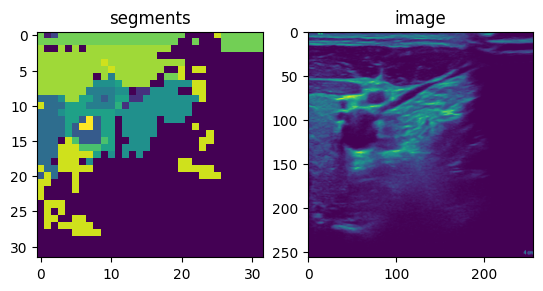

In [22]:
# visualisation
image_name="img0011"
image_path=os.path.join(main_data_dir, cfg.dataset.name, cfg.dataset.images_root, image_name+".jpg")
segm_path=os.path.join(output_multi_region_seg,image_name+".png")
im = np.array(Image.open(image_path))
segm = np.array(Image.open(segm_path))

fig, ax = plt.subplots(nrows=1, ncols=2)
ax1, ax2 = ax.flatten()

ax1.imshow(segm)
ax1.title.set_text("segments")
ax2.imshow(im)
ax2.title.set_text("image")

plt.show()

Found 20 image and segmap paths
Plots saved in the output directory: /home/guests/oleksandra_tmenova/test/project/thesis-codebase/deep-spectral-segmentation/extract/data/mutinfo_train_mini/plots/multiregion_segmaps


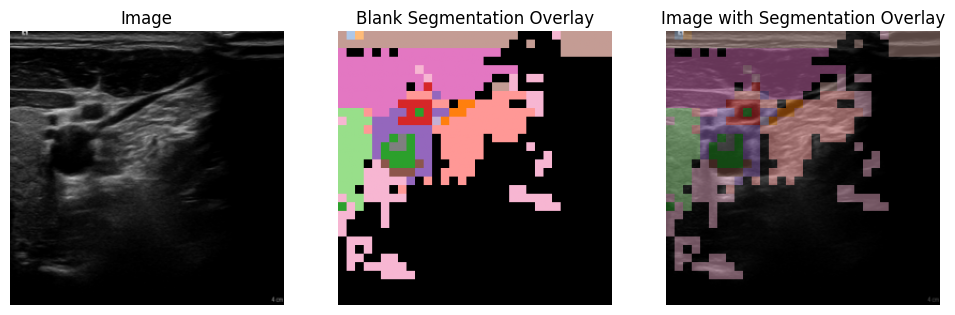

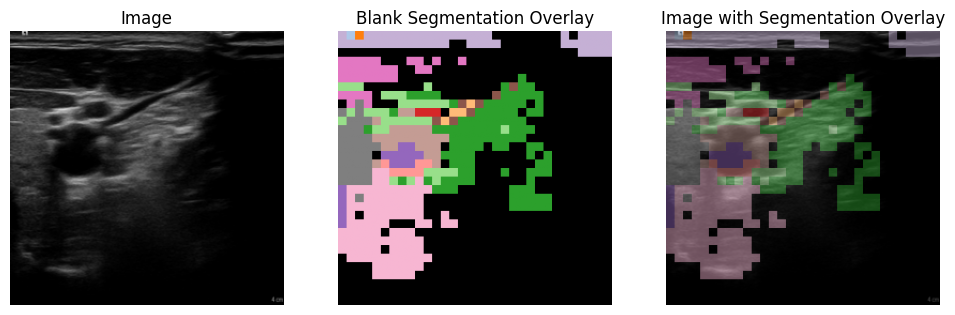

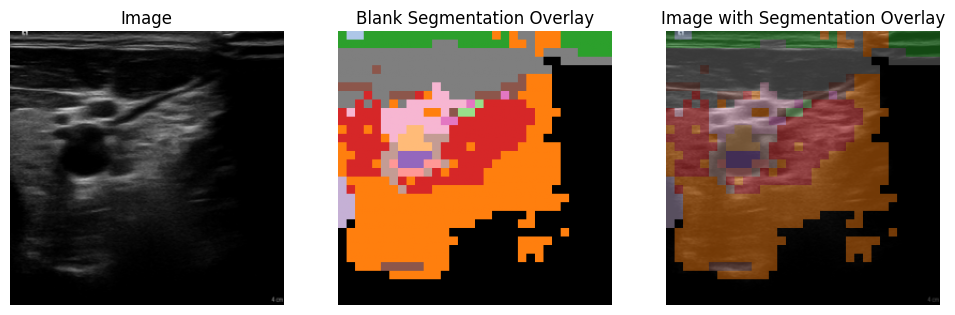

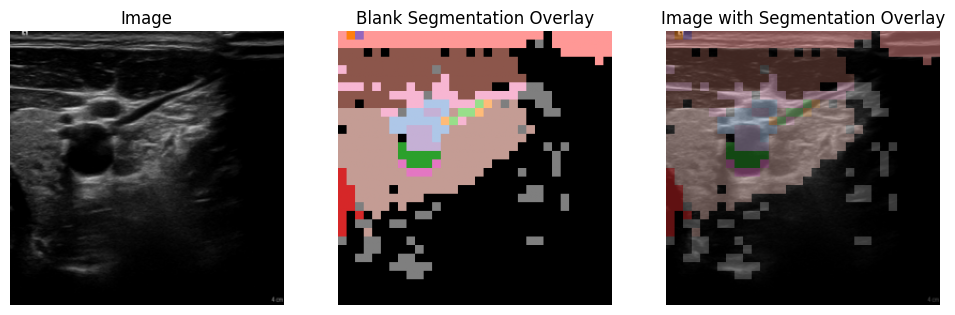

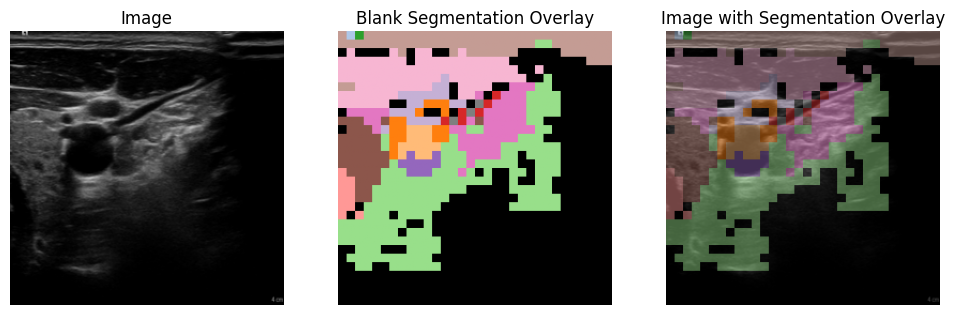

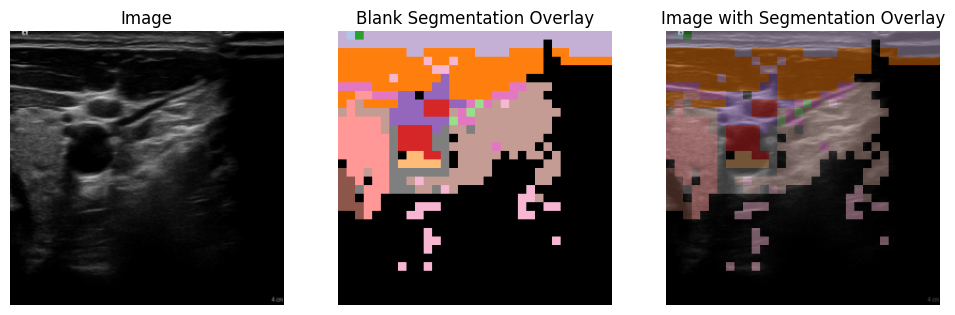

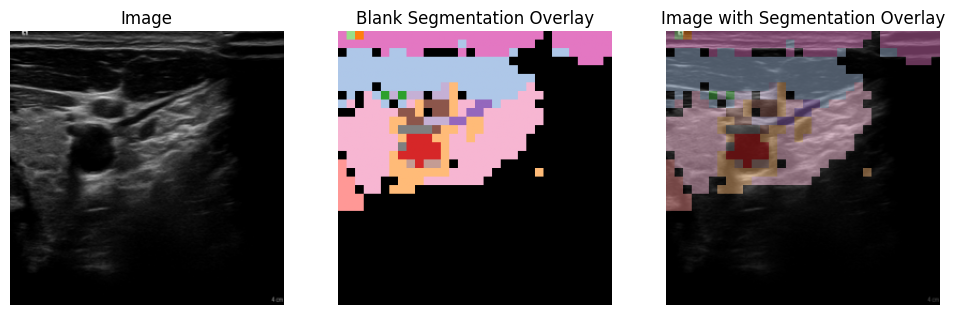

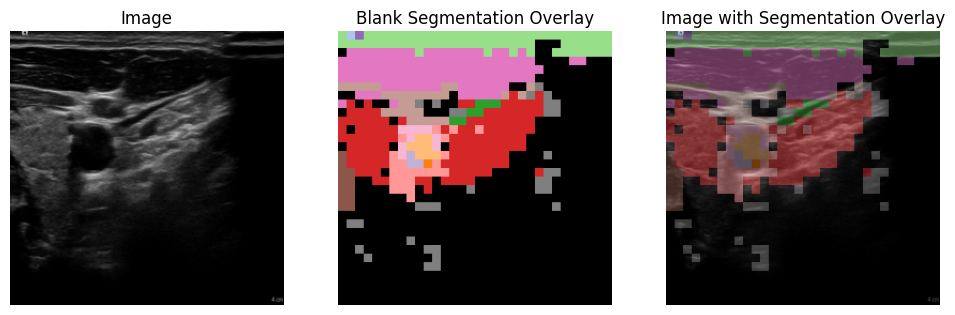

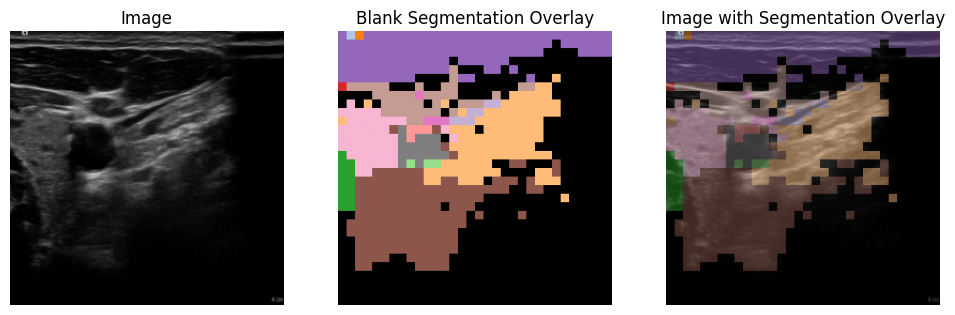

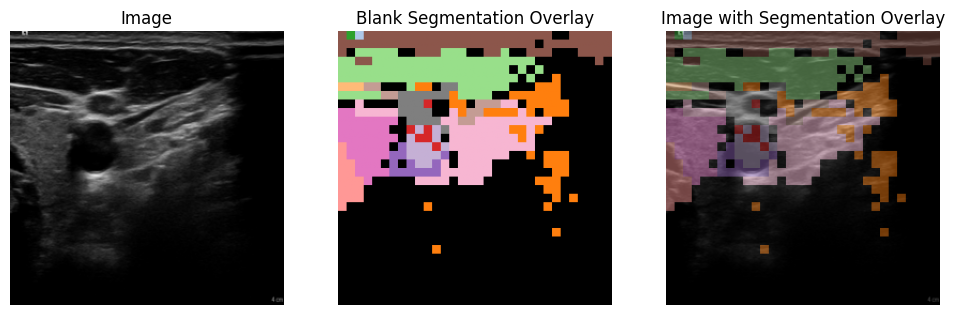

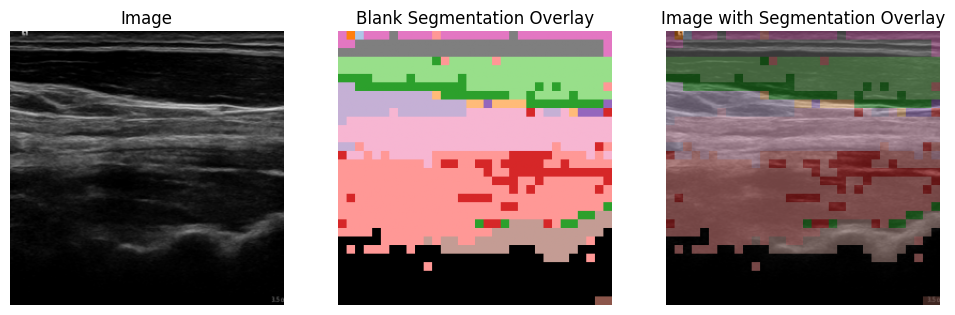

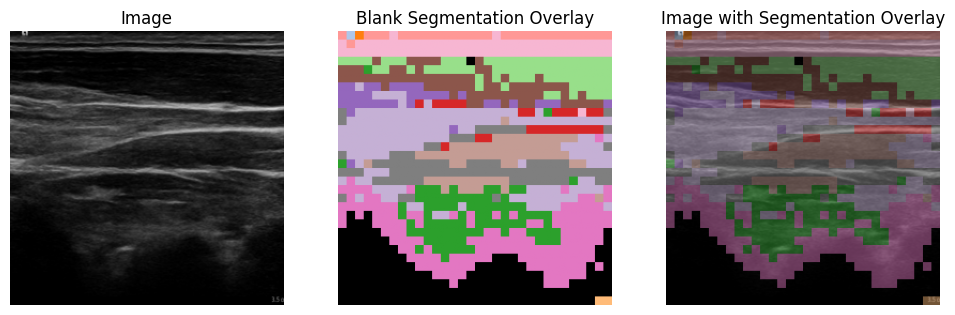

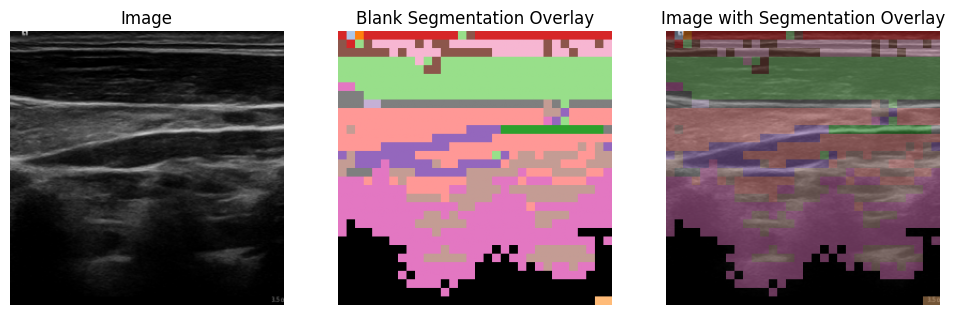

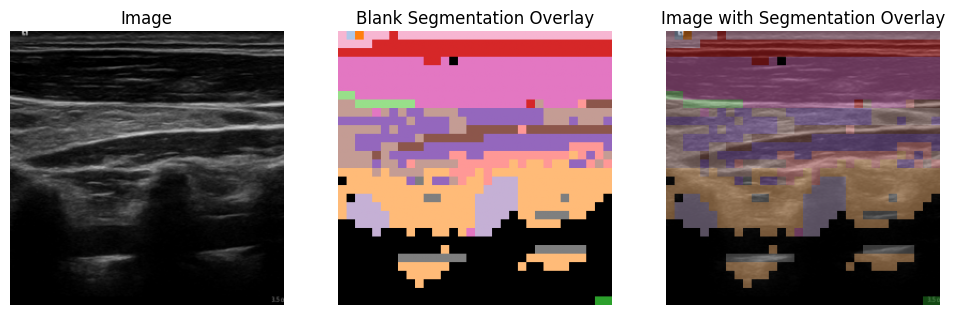

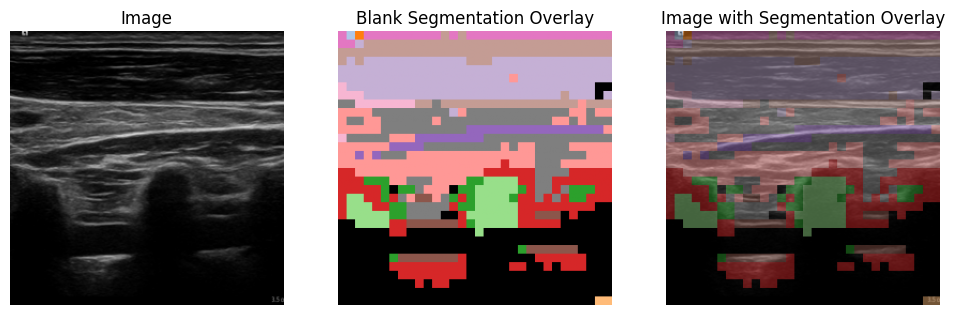

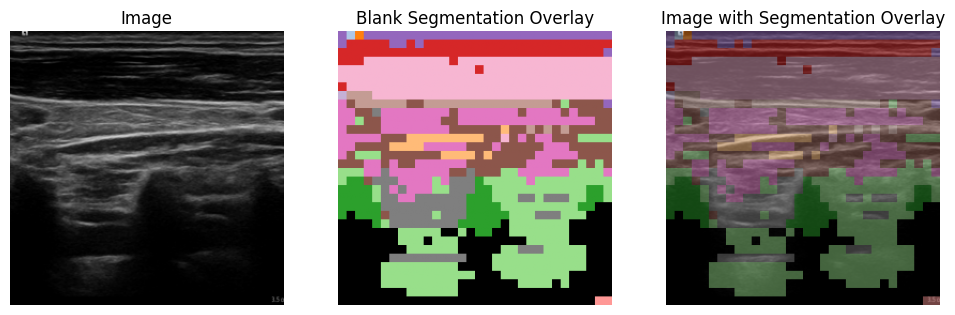

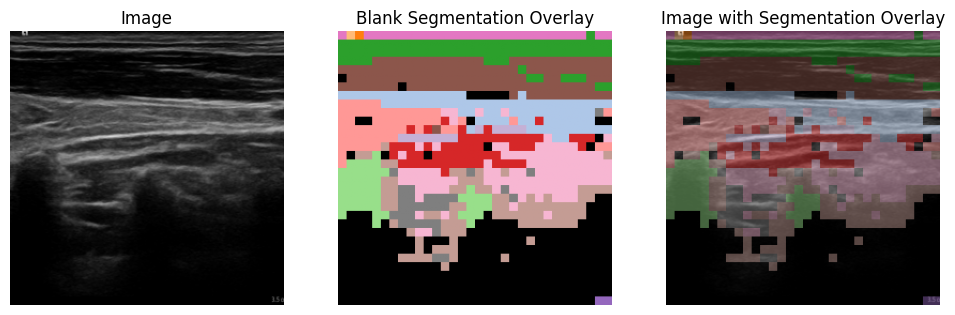

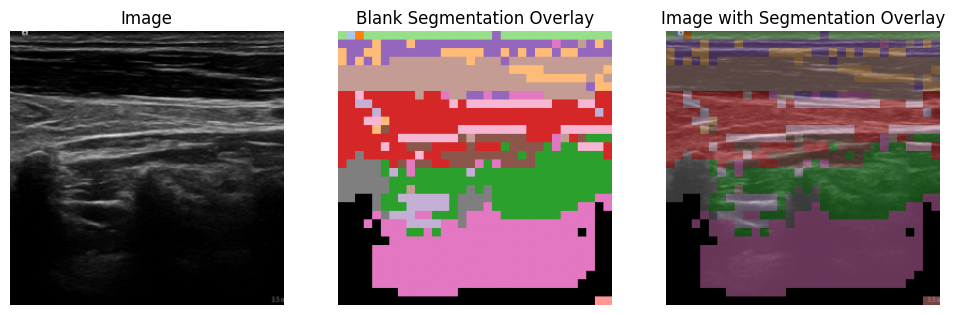

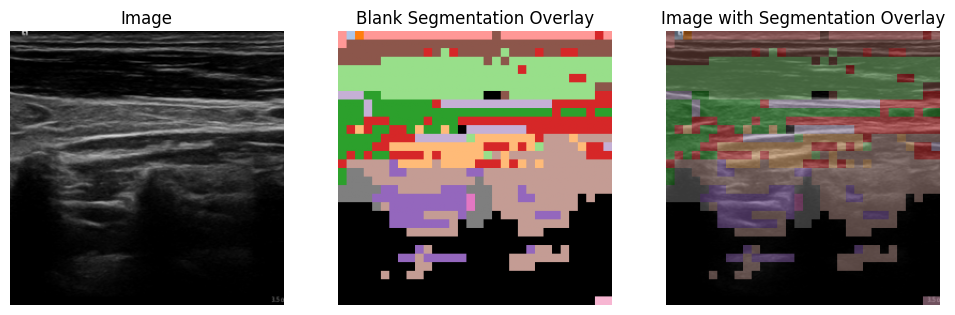

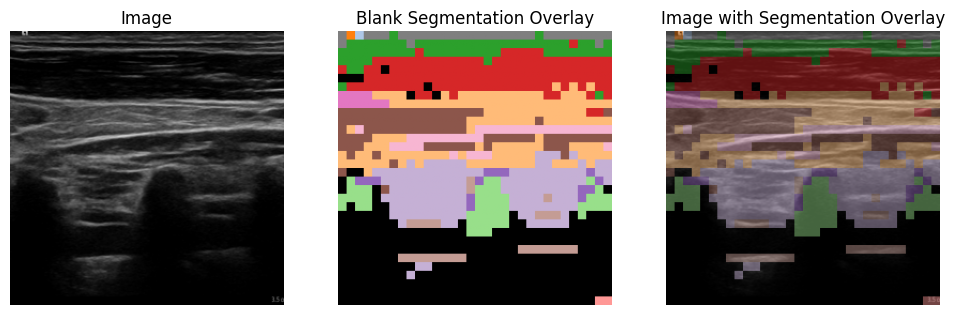

In [19]:
# Visualize multi-region segmentations
if cfg.vis.multiregion_segmaps:
    log.info("Plot multi region segmentations")
    output_segm_plots = os.path.join(path_to_save_data, 'plots', 'multiregion_segmaps')
    vis_utils.plot_segmentation(
        images_list = images_list,
        images_root = images_root,
        segmentations_dir = output_multi_region_seg,
        bbox_file = None,
        output_dir = output_segm_plots
    )

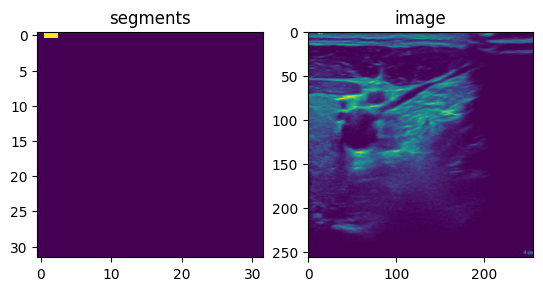

In [21]:
segmpath2="/home/guests/oleksandra_tmenova/test/project/thesis-codebase/deep-spectral-segmentation/outputs/pipeline/mutinfo_train_mini/2023-08-13--12-34-31/multi_region_segmentation/laplacian/img0011.png"
segm2 = np.array(Image.open(segmpath2))

fig, ax = plt.subplots(nrows=1, ncols=2)
ax1, ax2 = ax.flatten()

ax1.imshow(segm2)
ax1.title.set_text("segments")
ax2.imshow(im)
ax2.title.set_text("image")

plt.show()
